In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

In [4]:
from DomainPrediction.utils import helper
from DomainPrediction.utils.constants import *
from DomainPrediction.protein.base import BaseProtein

In [5]:
sys.path.append('../../esm')
from DomainPrediction.esm.esm3 import ESM3LM
from DomainPrediction.esm.esmc import ESMCLM

### Load DF and WildType

In [ ]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/round_3_exp'

df_gen = pd.read_csv(os.path.join(data_path, 'gen_seq.csv'))

In [ ]:
df_gen.head()

In [ ]:
gxps_protein = BaseProtein(file='/nethome/kgeorge/workspace/DomainPrediction/Data/gxps/gxps_ATC_AF.pdb')
gxps_T_domain = ''.join([gxps_protein.sequence[i] for i in range(len(gxps_protein.sequence)) if i not in A_gxps_atc+C_gxps_atc])
gxps_base_seq = gxps_protein.sequence

assert len(gxps_T_domain) == 115

### Zero-Shot Predictions - ESMC 600M

In [ ]:
esmc = ESMCLM(name='esmc_600m', device='gpu')

In [ ]:
y_pred = []
for i, row in tqdm(df_gen.iterrows()):

    masked_sequence = row['masked_sequence']
    
    esmc_score_wt_marginal, n_muts = esmc.get_wildtype_marginal(masked_sequence, gxps_T_domain)
    assert n_muts == row['n_mut']
    esmc_score_masked_marginal, n_muts = esmc.get_masked_marginal(masked_sequence, gxps_T_domain)
    assert n_muts == row['n_mut']
    esmc_score_pll = esmc.pseudolikelihood(masked_sequence)[0]


    full_sequence = row['sequence']
    
    esmc_full_score_wt_marginal, n_muts = esmc.get_wildtype_marginal(full_sequence, gxps_base_seq)
    assert n_muts == row['n_mut']
    esmc_full_score_masked_marginal, n_muts = esmc.get_masked_marginal(full_sequence, gxps_base_seq)
    assert n_muts == row['n_mut']

    y_pred.append({
        'esmc_wt_marginal': esmc_score_wt_marginal,
        'esmc_masked_marginal': esmc_score_masked_marginal,
        'esmc_pll': esmc_score_pll,

        'esmc_full_wt_marginal': esmc_full_score_wt_marginal,
        'esmc_full_masked_marginal': esmc_full_score_masked_marginal,
    })

In [ ]:
df_pred = pd.DataFrame(y_pred)

In [ ]:
df_pred.head()

In [ ]:
df_zero_shot_results = pd.concat([df_gen, df_pred], axis=1)

In [ ]:
df_zero_shot_results.to_csv(os.path.join(data_path, 'gen_zero_shot_results.csv'), index=False)

### Analyse Zero-shot predictions

In [6]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/round_3_exp'

df_gen = pd.read_csv(os.path.join(data_path, 'gen_zero_shot_results_sys.csv'))

In [7]:
df_gen.head()

,name,sequence,masked_sequence,n_mut,esmc_wt_marginal,esmc_masked_marginal,esmc_pll,esmc_full_wt_marginal,esmc_full_masked_marginal
0,gxps_ATC_esm3_str_gen_0,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSAADYPKEPYVAPEGEAEQLLAQIWMELLGVERVGRHDNFFALG...,49,-44.019165,-16.101318,-152.53116,-58.318970,-41.270752
1,gxps_ATC_esm3_str_gen_1,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSDTDYPRTPYIAPEGAVEETLAAIWQDLLQVERVGRHDSFFALG...,47,-41.208496,-12.600098,-149.14124,-52.558716,-31.674561
2,gxps_ATC_esm3_str_gen_2,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,EPQASDYPAVPYEAPEGEQEQLLAGIWQELLGVERVGRHDNFFALG...,46,-46.686646,-22.641846,-157.42130,-57.561768,-43.364258
3,gxps_ATC_esm3_str_gen_3,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APAEDSFDRAPYVAPEGEVEQTLAGIWQELLQVERVGRHDSFFELG...,49,-31.578125,-2.216797,-155.64465,-40.660645,-28.473633
4,gxps_ATC_esm3_str_gen_4,VCVHQLFEQQIEKTPDAIAVIYENQTLSYAELNARANRLAHQLIAL...,APSEDDYPKPPYVAPEGEVEQLLAKIWQELLGVEKVGRHDSFFALG...,43,-44.613281,-16.470703,-156.66013,-50.236816,-36.729492


<Axes: >

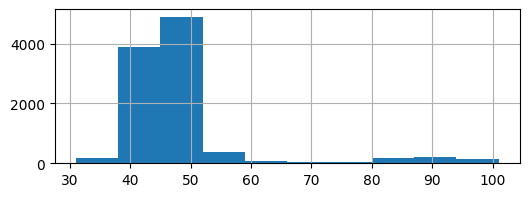

In [12]:
plt.figure(figsize=(6,2))
df_gen['n_mut'].hist()

no of esm3 sequences: 5000
no of evodiff sequences: 5000


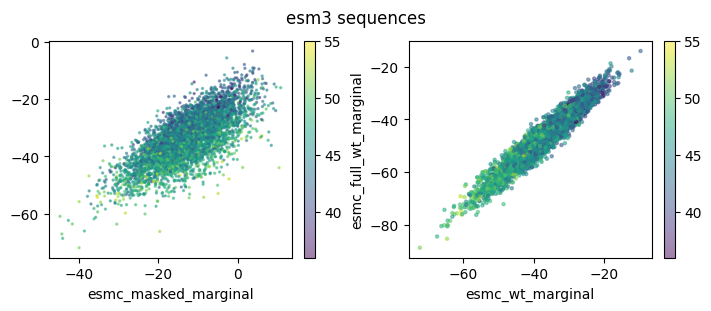

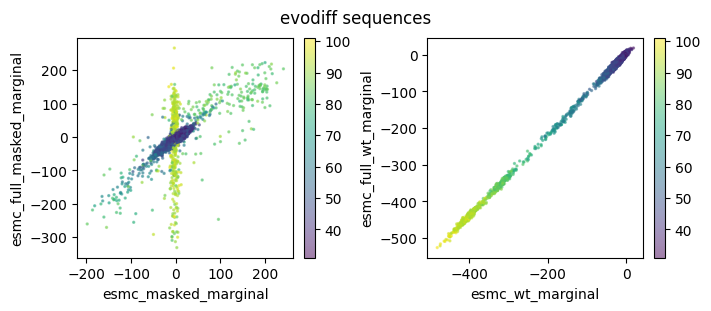

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout='constrained')

mask = df_gen['name'].str.contains('esm3')
print(f'no of esm3 sequences: {mask.sum()}')
im = ax[0].scatter(df_gen['esmc_masked_marginal'][mask], df_gen['esmc_full_masked_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[0].set_xlabel('esmc_masked_marginal')
fig.colorbar(im, ax=ax[0])
im = ax[1].scatter(df_gen['esmc_wt_marginal'][mask], df_gen['esmc_full_wt_marginal'][mask], alpha=0.5, s=5, c=df_gen['n_mut'][mask])
ax[1].set_xlabel('esmc_wt_marginal')
ax[1].set_ylabel('esmc_full_wt_marginal')
fig.colorbar(im, ax=ax[1])

fig.suptitle('esm3 sequences')

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout='constrained')

mask = df_gen['name'].str.contains('evodiff')
print(f'no of evodiff sequences: {mask.sum()}')
im = ax[0].scatter(df_gen['esmc_masked_marginal'][mask], df_gen['esmc_full_masked_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[0].set_xlabel('esmc_masked_marginal')
ax[0].set_ylabel('esmc_full_masked_marginal')
fig.colorbar(im, ax=ax[0])
im = ax[1].scatter(df_gen['esmc_wt_marginal'][mask], df_gen['esmc_full_wt_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[1].set_xlabel('esmc_wt_marginal')
ax[1].set_ylabel('esmc_full_wt_marginal')
fig.colorbar(im, ax=ax[1])

fig.suptitle('evodiff sequences')

plt.show()

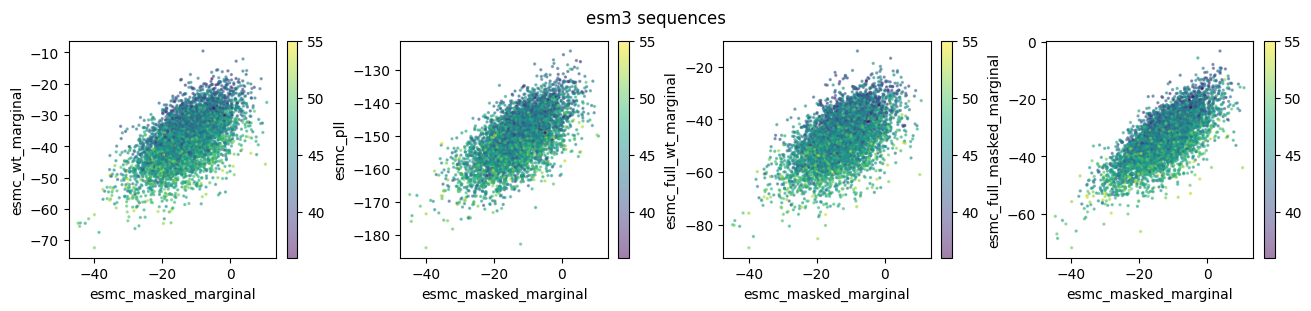

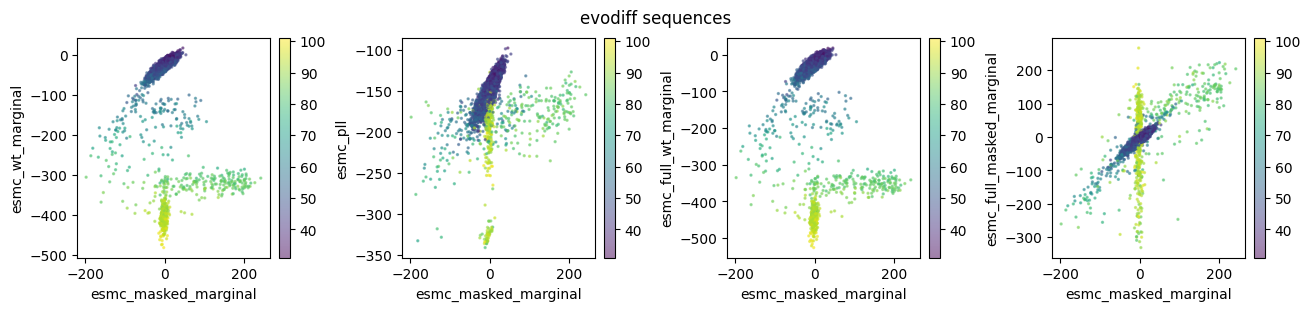

In [44]:
predictors = ['esmc_wt_marginal', 'esmc_pll', 'esmc_full_wt_marginal', 'esmc_full_masked_marginal']
x_anchor = 'esmc_masked_marginal'

fig, ax = plt.subplots(1, 4, figsize=(13, 3), layout='constrained')
mask = df_gen['name'].str.contains('esm3')
for i, ax_ in enumerate(ax.flatten()):
    im = ax_.scatter(df_gen[x_anchor][mask], df_gen[predictors[i]][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
    ax_.set_xlabel(x_anchor)
    ax_.set_ylabel(predictors[i])
    fig.colorbar(im, ax=ax_)
fig.suptitle('esm3 sequences')

fig, ax = plt.subplots(1, 4, figsize=(13, 3), layout='constrained')
mask = df_gen['name'].str.contains('evodiff')
for i, ax_ in enumerate(ax.flatten()):
    im = ax_.scatter(df_gen[x_anchor][mask], df_gen[predictors[i]][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
    ax_.set_xlabel(x_anchor)
    ax_.set_ylabel(predictors[i])
    fig.colorbar(im, ax=ax_)
fig.suptitle('evodiff sequences')

plt.show()

no of esm3 sequences: 4960
no of evodiff sequences: 3933


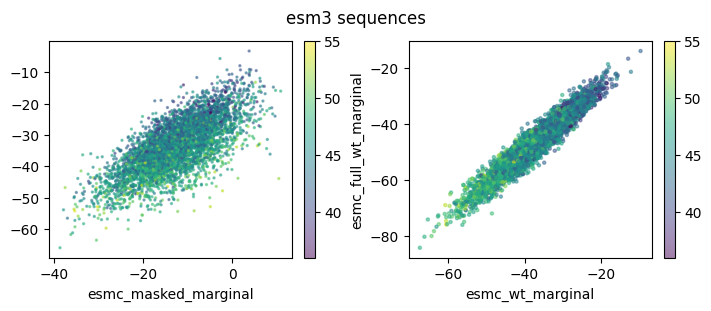

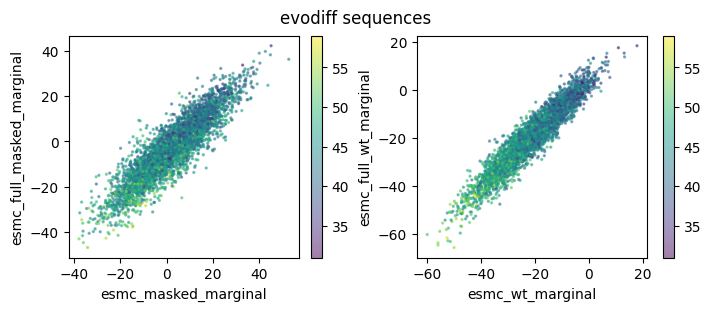

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout='constrained')

filter_mask = (df_gen['esmc_wt_marginal'] > -100) & (df_gen['esmc_pll'] > -170) & (df_gen['esmc_masked_marginal'] > -40)

mask = df_gen['name'].str.contains('esm3') & filter_mask
print(f'no of esm3 sequences: {mask.sum()}')
im = ax[0].scatter(df_gen['esmc_masked_marginal'][mask], df_gen['esmc_full_masked_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[0].set_xlabel('esmc_masked_marginal')
fig.colorbar(im, ax=ax[0])
im = ax[1].scatter(df_gen['esmc_wt_marginal'][mask], df_gen['esmc_full_wt_marginal'][mask], alpha=0.5, s=5, c=df_gen['n_mut'][mask])
ax[1].set_xlabel('esmc_wt_marginal')
ax[1].set_ylabel('esmc_full_wt_marginal')
fig.colorbar(im, ax=ax[1])

fig.suptitle('esm3 sequences')

fig, ax = plt.subplots(1, 2, figsize=(7, 3), layout='constrained')

mask = df_gen['name'].str.contains('evodiff') & filter_mask
print(f'no of evodiff sequences: {mask.sum()}')
im = ax[0].scatter(df_gen['esmc_masked_marginal'][mask], df_gen['esmc_full_masked_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[0].set_xlabel('esmc_masked_marginal')
ax[0].set_ylabel('esmc_full_masked_marginal')
fig.colorbar(im, ax=ax[0])
im = ax[1].scatter(df_gen['esmc_wt_marginal'][mask], df_gen['esmc_full_wt_marginal'][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
ax[1].set_xlabel('esmc_wt_marginal')
ax[1].set_ylabel('esmc_full_wt_marginal')
fig.colorbar(im, ax=ax[1])

fig.suptitle('evodiff sequences')

plt.show()

no of esm3 sequences: 4960
no of evodiff sequences: 3933


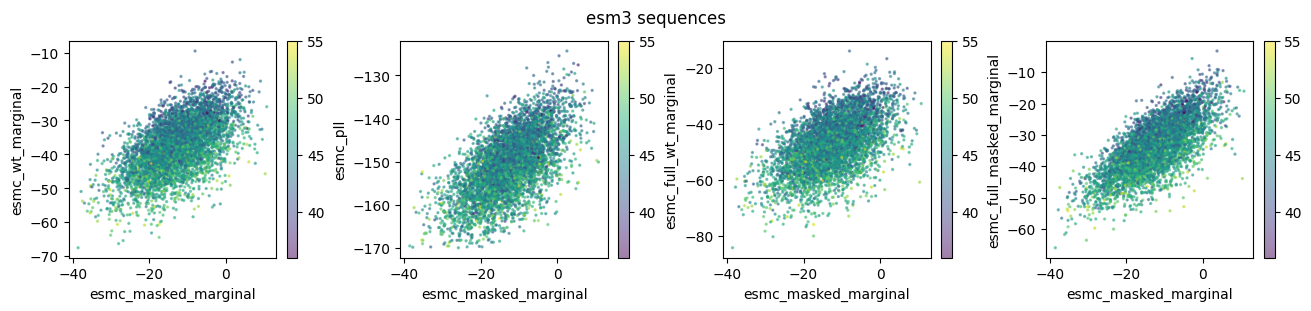

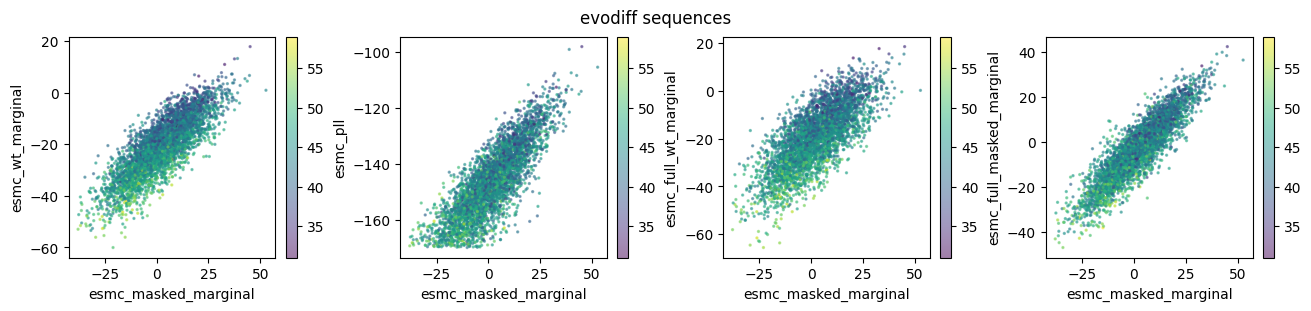

In [56]:
predictors = ['esmc_wt_marginal', 'esmc_pll', 'esmc_full_wt_marginal', 'esmc_full_masked_marginal']
x_anchor = 'esmc_masked_marginal'

filter_mask = (df_gen['esmc_wt_marginal'] > -100) & (df_gen['esmc_pll'] > -170) & (df_gen['esmc_masked_marginal'] > -40)

fig, ax = plt.subplots(1, 4, figsize=(13, 3), layout='constrained')
mask = df_gen['name'].str.contains('esm3') & filter_mask
print(f'no of esm3 sequences: {mask.sum()}')
for i, ax_ in enumerate(ax.flatten()):
    im = ax_.scatter(df_gen[x_anchor][mask], df_gen[predictors[i]][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
    ax_.set_xlabel(x_anchor)
    ax_.set_ylabel(predictors[i])
    fig.colorbar(im, ax=ax_)
fig.suptitle('esm3 sequences')

fig, ax = plt.subplots(1, 4, figsize=(13, 3), layout='constrained')
mask = df_gen['name'].str.contains('evodiff') & filter_mask
print(f'no of evodiff sequences: {mask.sum()}')
for i, ax_ in enumerate(ax.flatten()):
    im = ax_.scatter(df_gen[x_anchor][mask], df_gen[predictors[i]][mask], alpha=0.5, s=2, c=df_gen['n_mut'][mask])
    ax_.set_xlabel(x_anchor)
    ax_.set_ylabel(predictors[i])
    fig.colorbar(im, ax=ax_)
fig.suptitle('evodiff sequences')

plt.show()

In [57]:
filter_mask = (df_gen['esmc_wt_marginal'] > -100) & (df_gen['esmc_pll'] > -170) & (df_gen['esmc_masked_marginal'] > -40)
df_filtered = df_gen[filter_mask]

In [58]:
df_filtered.shape

(8893, 10)

In [59]:
df_filtered.to_csv(os.path.join(data_path, 'gen_zero_shot_filtered.csv'), index=False)